## Load data

In [2]:
import pandas as pd

file_path = r".\GSE74322_2015.02.24.HMVEC_LYvsHMVEC_BL.txt"

columns_to_keep = ['LYM1.raw', 'LYM2.raw', 'LYM3.raw',
                   'BLM1.raw', 'BLM2.raw', 'BLM3.raw', 
                   'Symbol']
counts = pd.read_csv(file_path, sep='\t', usecols=columns_to_keep)

counts.rename(columns={'LYM1.raw': 'LYM1', 
                       'LYM2.raw': 'LYM2', 
                       'LYM3.raw': 'LYM3', 
                       'BLM1.raw': 'BLM1', 
                       'BLM2.raw': 'BLM2', 
                       'BLM3.raw': 'BLM3',}, inplace=True)

counts.set_index('Symbol', inplace=True)
counts = counts.groupby(counts.index).sum() 

counts

,BLM1,BLM2,BLM3,LYM1,LYM2,LYM3
Symbol,,,,,,
61E3.4,529,479,744,916,658,878
A1BG-AS1,107,101,132,167,131,112
A2M,5930,5040,6249,1650,5403,4092
A2M-AS1,47,28,74,13,44,52
A4GALT,2045,1815,2239,3391,2492,4407
...,...,...,...,...,...,...
hsa-mir-146a,172,141,181,321,253,243
hsa-mir-3654,3483,3924,4995,4401,3333,5474
hsa-mir-6080,160,187,228,348,228,282


## Analyse counts

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
gene_nodes = ["PROX1", "PDPN", "FLT4", "LYVE1", 
    "NOTCH1","NOTCH2", "NOTCH3", "NOTCH4", "DLL1", "DLL3", "DLL4", "JAG1", "JAG2", 
    "VLDLR", "LRP8", "RELN", "DAB1", "DAB2", "SH3KBP1", "FYN",
    "MIB1", "MIB2", "NEURL1", "NEURL2", "NEURL3", "NEURL4", 
    "ADAM10", "ADAM17", 
    "PSEN1", "PSEN2", "PSENEN", "APH1A", "APH1B", "NCSTN", 
    "KPNA4", "KPNA3", "KPNA6", 
    "TBL1X", "HDAC3", "NCOR1", "NCOR2", "RBPJ", "SNW1", 
    "MAML1", "MAML2", "MAML3", "KAT2B", "EP300", "CREBBP", 
    "CDK8", "CCNC",
    "SKP1", "RBX1", "CUL1", "FBXW7",
    "HES1", "HES5", "HEY1", "HEY2", "HEYL", "MYC"]

missing_genes = set(gene_nodes) - set(counts.index)
print("Missing genes:", missing_genes)

Missing genes: {'HES5', 'HEYL', 'APH1A', 'NEURL1', 'DAB1'}


<Figure size 1600x1000 with 0 Axes>

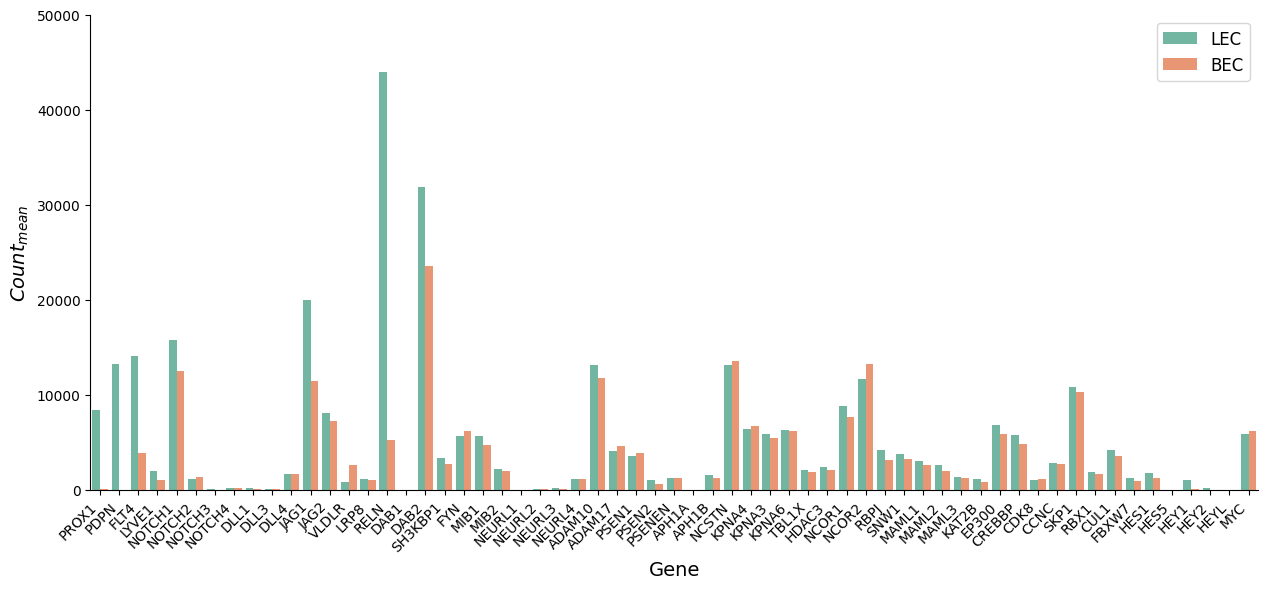

,Gene,Condition,Mean_Count
0,ADAM10,LEC,13095.000000
1,ADAM17,LEC,4074.666667
2,APH1B,LEC,1567.333333
3,CCNC,LEC,2853.000000
4,CDK8,LEC,1017.333333
...,...,...,...
107,SH3KBP1,BEC,2748.333333
108,SKP1,BEC,10249.333333
109,SNW1,BEC,3210.333333
110,TBL1X,BEC,1824.666667


In [5]:
filtered_counts = counts.loc[counts.index.intersection(gene_nodes)]

conditions = {
    "LEC": ["LYM1", "LYM2", "LYM3"],
    "BEC": ["BLM1", "BLM2", "BLM3"],
}

mean_counts = pd.DataFrame({cond: filtered_counts[samples].mean(axis=1) for cond, samples in conditions.items()})
mean_counts["Gene"] = mean_counts.index
melted = mean_counts.melt(id_vars="Gene", var_name="Condition", value_name="Mean_Count")

plt.figure(figsize=(16, 10))
g = sns.catplot(
    data=melted, x="Gene", y="Mean_Count", hue="Condition", kind="bar",
    height=6, aspect=2, palette="Set2", order=gene_nodes
)
g.set_xticklabels(rotation=45, ha='right', fontsize=10)
g.set_yticklabels(fontsize=10)
g.set_axis_labels("Gene", r"$Count_{mean}$", fontsize=14)
g._legend.remove()
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()
melted

<Figure size 1600x1000 with 0 Axes>

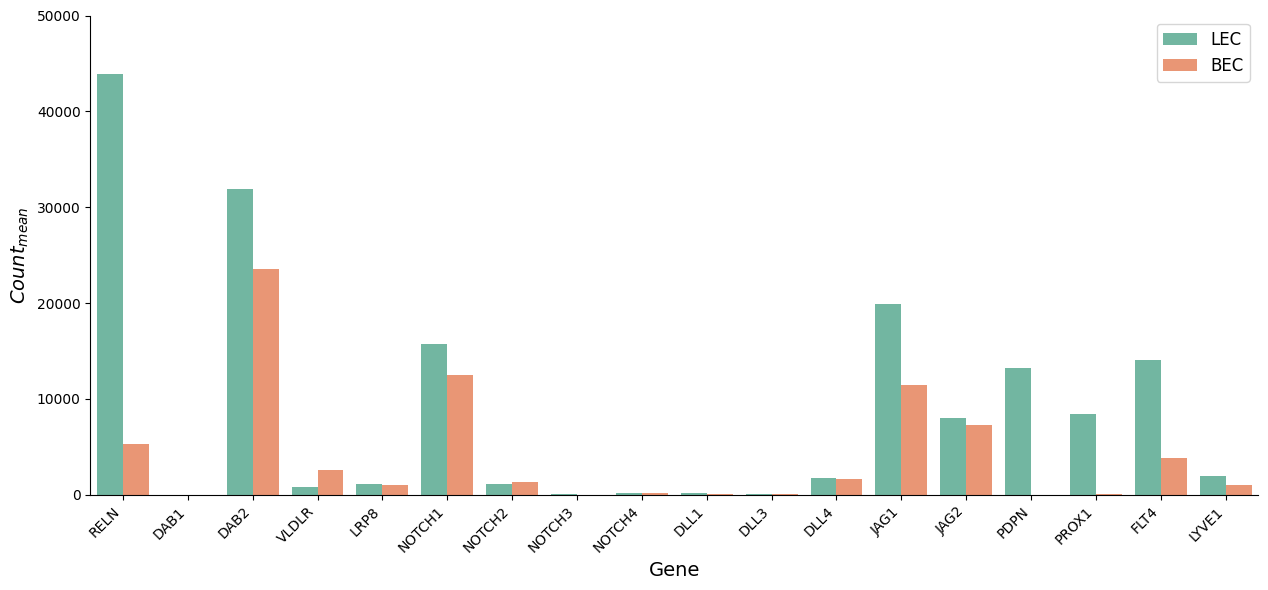

In [6]:
few_gene_nodes = ["RELN", "DAB1", "DAB2", "VLDLR", "LRP8", 
                  "NOTCH1", "NOTCH2", "NOTCH3", "NOTCH4", 
                  "DLL1", "DLL3", "DLL4", "JAG1", "JAG2", 
                  "PDPN", "PROX1", "FLT4", "LYVE1"]

plt.figure(figsize=(16, 10))
g = sns.catplot(
    data=melted, x="Gene", y="Mean_Count", hue="Condition", kind="bar",
    height=6, aspect=2, palette="Set2", order=few_gene_nodes
)
g.set_xticklabels(rotation=45, ha='right', fontsize=10)
g.set_yticklabels(fontsize=10)
g.set_axis_labels("Gene", r"$Count_{mean}$", fontsize=14)
g._legend.remove()
plt.tight_layout()
plt.legend(fontsize=12, loc='best')
plt.show()

<span style="color:red">Commentary</span>: Raw read counts alone are not sufficient to compare expression levels among samples, as these values are affected by factors such as transcript length, total number of reads, and sequencing biases. https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0881-8 (doi: 10.1186/s13059-016-0881-8). But the counts show that DAB1 is not expressed in the dataset.

## 1st method: normalize by the highest value for each sample

In [7]:
normalized_counts = counts.divide(counts.max())
max_indices = counts.idxmax()  

print('Genes having the highest counts per sample:\n')
for sample in counts.columns:
    gene = max_indices[sample]
    value = counts.at[gene, sample]
    print(f"{sample}: {gene} (Count value: {value:.3f})")
    
lec_markers = ['PROX1', 'PDPN', 'LYVE1', 'FLT4']

print('\nRaw counts for LEC markers:\n')
for gene in lec_markers:
    if gene in counts.index:
        values = counts.loc[gene]
        print(f"{gene}:")
        for sample, value in values.items():
            print(f"  {sample}: {value:.3f}")
    else:
        print(f"{gene}: not found in counts")

Genes having the highest counts per sample:

BLM1: SERPINE1 (Count value: 774357.000)
BLM2: SERPINE1 (Count value: 754056.000)
BLM3: SERPINE1 (Count value: 901865.000)
LYM1: FN1 (Count value: 929797.000)
LYM2: FN1 (Count value: 825605.000)
LYM3: HSPG2 (Count value: 733375.000)

Raw counts for LEC markers:

PROX1:
  BLM1: 17.000
  BLM2: 58.000
  BLM3: 49.000
  LYM1: 10272.000
  LYM2: 5861.000
  LYM3: 9058.000
PDPN:
  BLM1: 11.000
  BLM2: 17.000
  BLM3: 20.000
  LYM1: 17562.000
  LYM2: 8858.000
  LYM3: 13241.000
LYVE1:
  BLM1: 877.000
  BLM2: 1329.000
  BLM3: 745.000
  LYM1: 1265.000
  LYM2: 1329.000
  LYM3: 3311.000
FLT4:
  BLM1: 3528.000
  BLM2: 4437.000
  BLM3: 3643.000
  LYM1: 15482.000
  LYM2: 9463.000
  LYM3: 17384.000


<span style="color:red">Commentary</span>: Normalizing each sample independently by its highest expression value results in non-interpretable outputs, particularly for genes with relatively low expression. This approach causes lymphatic endothelial cell (LEC) markers such as PDPN, PROX1, LYVE-1, and FLT4 to appear artificially suppressed, often approaching zero. Consequently, this method fails to reflect the actual biological variability or relative gene activity between samples. Moreover, it cannot provide meaningful insights into the likelihood of a gene being transcriptionally active or inactive, as the normalization distorts the relative expression landscape across the dataset.


## 2nd method: normalize by the highest value for each sample conserving only the genes related to the map

In [8]:
counts_2nd = counts.loc[counts.index.intersection(gene_nodes)]
counts_2nd


,BLM1,BLM2,BLM3,LYM1,LYM2,LYM3
Symbol,,,,,,
ADAM10,9469,11261,14497,12447,13182,13656
ADAM17,3446,4577,5763,3266,4614,4344
APH1B,948,1346,1321,1360,1672,1670
CCNC,2121,2407,3461,3414,2262,2883
CDK8,954,1026,1312,1008,855,1189
CREBBP,3541,4676,6144,6115,4905,6103
CUL1,2906,3501,4380,4369,3684,4489
DAB2,18952,24638,27141,30502,33552,31497
DLL1,42,74,88,124,179,199


In [9]:
normalized_counts = counts_2nd.divide(counts_2nd.max(), axis=1)
max_indices = counts_2nd.idxmax() 

print('Genes having the highest counts per sample:\n')
for sample in counts.columns:
    gene = max_indices[sample]
    value = counts.at[gene, sample]
    print(f"{sample}: {gene} (Count value: {value:.3f})")
    
normalized_counts

Genes having the highest counts per sample:

BLM1: DAB2 (Count value: 18952.000)
BLM2: DAB2 (Count value: 24638.000)
BLM3: DAB2 (Count value: 27141.000)
LYM1: RELN (Count value: 39008.000)
LYM2: RELN (Count value: 43438.000)
LYM3: RELN (Count value: 49370.000)


,BLM1,BLM2,BLM3,LYM1,LYM2,LYM3
Symbol,,,,,,
ADAM10,0.499631,0.457058,0.534137,0.319088,0.303467,0.276605
ADAM17,0.181828,0.185770,0.212336,0.083726,0.106220,0.087989
APH1B,0.050021,0.054631,0.048672,0.034865,0.038492,0.033826
CCNC,0.111914,0.097695,0.127519,0.087521,0.052074,0.058396
CDK8,0.050338,0.041643,0.048340,0.025841,0.019683,0.024083
CREBBP,0.186840,0.189788,0.226373,0.156763,0.112920,0.123618
CUL1,0.153335,0.142098,0.161379,0.112003,0.084811,0.090926
DAB2,1.000000,1.000000,1.000000,0.781942,0.772411,0.637979
DLL1,0.002216,0.003003,0.003242,0.003179,0.004121,0.004031


<span style="color:red">Commentary</span>: Normalizing each sample independently by its maximum expression value distorts the biological relevance of the data, especially when applied to input state initialization in a Boolean model. This method disproportionately downscales moderately or even highly expressed model-relevant genes when a few unrelated genes dominate the expression profile. As a result, critical regulators such as NOTCH1 or RELN receive artificially low probabilities, failing to represent their true biological activity. This compression of expression values toward zero also hampers the ability to distinguish active from inactive states across samples. Therefore, this normalization strategy is unsuitable for defining biologically meaningful initial conditions in MaBoSS simulations and was excluded from further analysis.

## Use log2 to reduce difference of expression

In [10]:
import numpy as np

In [11]:
counts_log2 = np.log2(counts + 1)
counts_log2

,BLM1,BLM2,BLM3,LYM1,LYM2,LYM3
Symbol,,,,,,
61E3.4,9.049849,8.906891,9.541097,9.840778,9.364135,9.779719
A1BG-AS1,6.754888,6.672425,7.055282,7.392317,7.044394,6.820179
A2M,12.534060,12.299494,12.609640,10.689124,12.399812,11.998943
A2M-AS1,5.584963,4.857981,6.228819,3.807355,5.491853,5.727920
A4GALT,10.998590,10.826548,11.129283,11.727920,11.283667,12.105909
...,...,...,...,...,...,...
hsa-mir-146a,7.434628,7.149747,7.507795,8.330917,7.988685,7.930737
hsa-mir-3654,11.766529,11.938477,12.286558,12.103943,11.703038,12.418643
hsa-mir-6080,7.330917,7.554589,7.839204,8.447083,7.839204,8.144658


<Figure size 1600x1000 with 0 Axes>

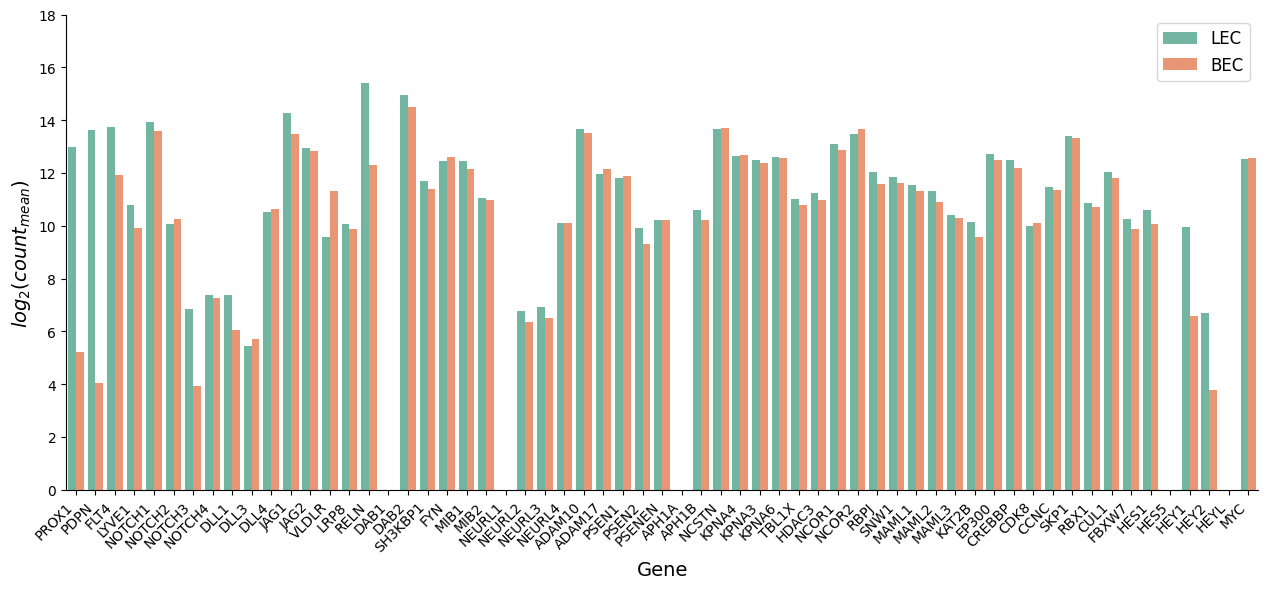

In [12]:
filtered_counts_log2 = counts_log2.loc[counts_log2.index.intersection(gene_nodes)]

conditions = {
    "LEC": ["LYM1", "LYM2", "LYM3"],
    "BEC": ["BLM1", "BLM2", "BLM3"],
}

mean_counts_log2 = pd.DataFrame({cond: filtered_counts_log2[samples].mean(axis=1) for cond, samples in conditions.items()})
mean_counts_log2["Gene"] = mean_counts_log2.index
melted_log2 = mean_counts_log2.melt(id_vars="Gene", var_name="Condition", value_name="Mean_Count")

plt.figure(figsize=(16, 10))
g = sns.catplot(
    data=melted_log2, x="Gene", y="Mean_Count", hue="Condition", kind="bar",
    height=6, aspect=2, palette="Set2", order=gene_nodes
)
g.set_xticklabels(rotation=45, ha='right', fontsize=10)
g.set_yticklabels(fontsize=10)
g.set_axis_labels("Gene", r"$log_2$($count_{mean}$)", fontsize=14)
g._legend.remove()
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()

<Figure size 1600x1000 with 0 Axes>

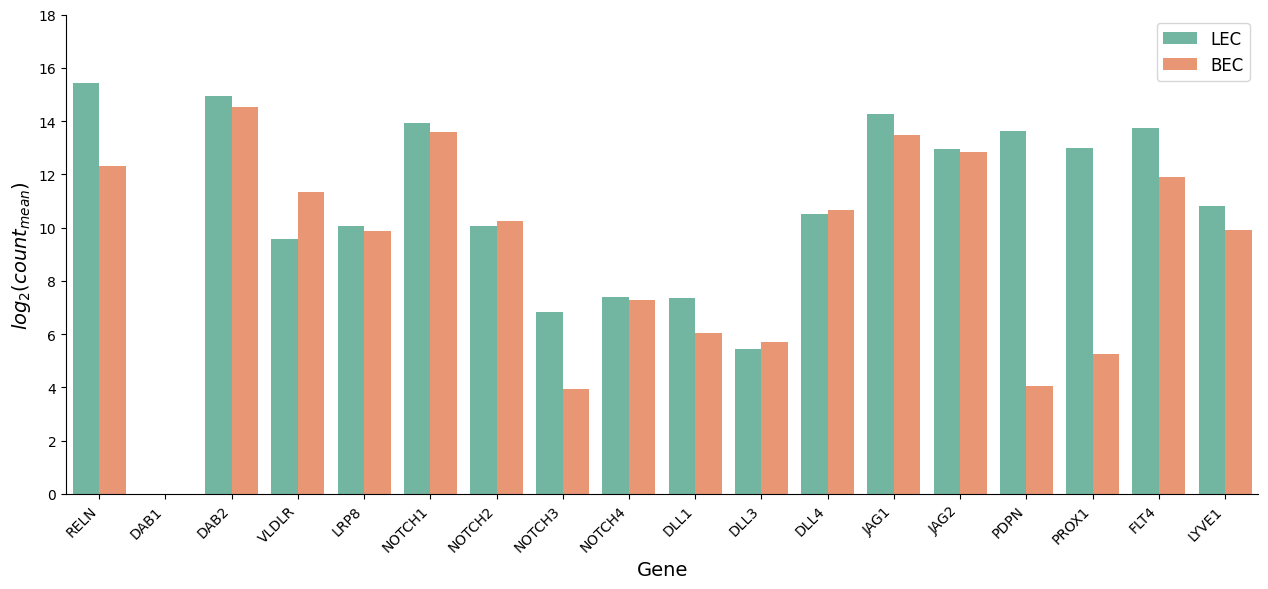

In [13]:
few_gene_nodes = ["RELN", "DAB1", "DAB2", "VLDLR", "LRP8", 
                  "NOTCH1", "NOTCH2", "NOTCH3", "NOTCH4", 
                  "DLL1", "DLL3", "DLL4", "JAG1", "JAG2", 
                  "PDPN", "PROX1", "FLT4", "LYVE1"]

plt.figure(figsize=(16, 10))
g = sns.catplot(
    data=melted_log2, x="Gene", y="Mean_Count", hue="Condition", kind="bar",
    height=6, aspect=2, palette="Set2", order=few_gene_nodes
)
g.set_xticklabels(rotation=45, ha='right', fontsize=10)
g.set_yticklabels(fontsize=10)
g.set_axis_labels("Gene", r"$log_2$($count_{mean}$)", fontsize=14)
g._legend.remove()
plt.tight_layout()
plt.legend(fontsize=12, loc='best')
plt.show()

## 3rd method: normalizing using DESeq2 (as done by Ahmed) --> Inter sample comparison not within sample comparison

In [14]:
from pydeseq2.dds import DeseqDataSet
import pandas as pd
import os

In [15]:
counts_T = counts.T

metadata = pd.DataFrame(zip(counts_T.index, ['LYM', 'LYM', 'LYM',
                                           'BLM', 'BLM', 'BLM']), 
                        columns = ['Sample', 'Condition'])
metadata = metadata.set_index('Sample')

GSE_name = "GSE74322"
os.makedirs(f"{GSE_name}_outputs", exist_ok=True)
metadata.to_csv(r'.\GSE74322_outputs\GSE74322_DESeq2_metadata.csv', sep=',')

metadata

,Condition
Sample,
BLM1,LYM
BLM2,LYM
BLM3,LYM
LYM1,BLM
LYM2,BLM
LYM3,BLM


In [16]:
dds = DeseqDataSet(counts=counts_T, metadata=metadata, design_factors='Condition')
dds.deseq2()
dds

C:\Users\Yanis\AppData\Local\Temp\ipykernel_29100\1947885380.py:1: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(counts=counts_T, metadata=metadata, design_factors='Condition')
Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.31 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 1.59 seconds.

Fitting LFCs...
... done in 0.82 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



AnnData object with n_obs × n_vars = 6 × 14280
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [17]:
import numpy as np

In [18]:
normed_counts_df = pd.DataFrame(
    dds.layers['normed_counts'].T,
    index=dds.var_names,
    columns=dds.obs_names
)

normed_counts_df = normed_counts_df.loc[normed_counts_df.index.intersection(gene_nodes)]
normed_counts_df.to_csv(r'.\GSE74322_outputs\GSE74322_DESeq2_norm.csv', sep=',')
normed_counts_df

Sample,BLM1,BLM2,BLM3,LYM1,LYM2,LYM3
Symbol,,,,,,
ADAM10,12417.162697,11987.981016,12553.528460,11623.459990,13202.832749,11886.442921
ADAM17,4518.908296,4872.479275,4990.410741,3049.909241,4621.291936,3781.100472
APH1B,1243.158754,1432.894277,1143.906401,1270.017320,1674.642418,1453.599859
CCNC,2781.371009,2562.389691,2997.017452,3188.117009,2265.574850,2509.418200
CDK8,1251.026847,1092.235905,1136.112943,941.306955,856.351237,1034.928283
CREBBP,4643.486441,4977.870458,5320.333784,5710.408760,4912.751831,5312.167629
CUL1,3810.779892,3727.015499,3792.816076,4079.930642,3689.822170,3907.311238
DAB2,24852.684279,26228.565517,23502.470576,28483.873755,33605.025367,27415.589681
DLL1,55.076654,78.777248,76.202697,115.795697,179.282890,173.213396


<Figure size 1600x1000 with 0 Axes>

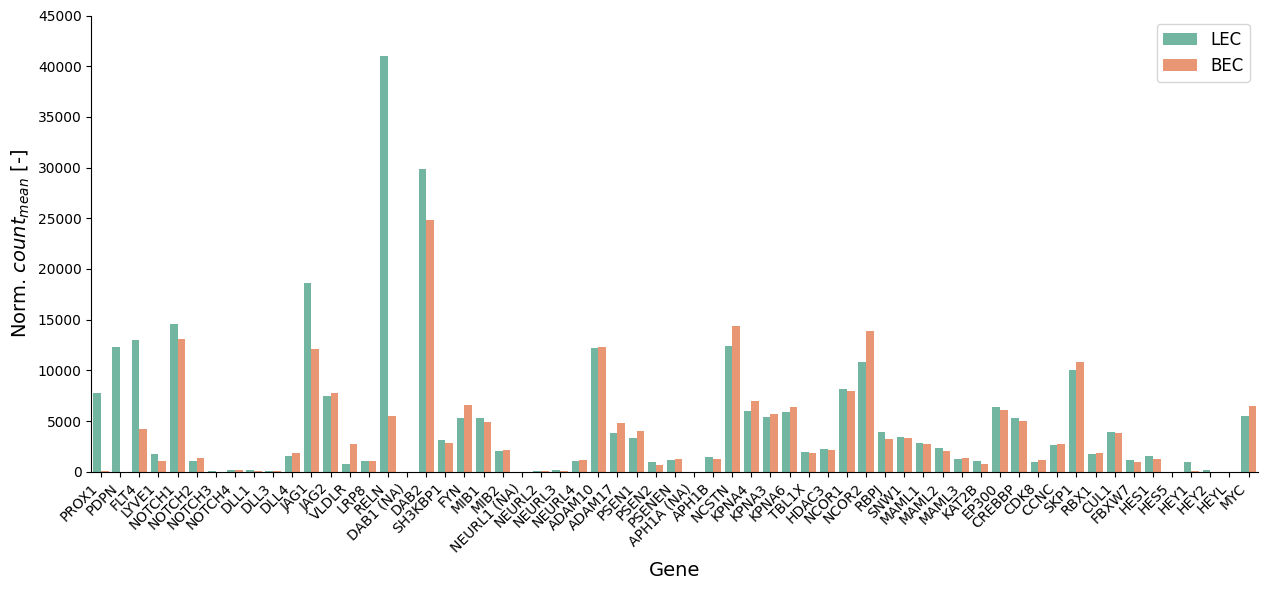

,Gene,Condition,Mean_Count
0,ADAM10,LEC,12237.578553
1,ADAM17,LEC,3817.433883
2,APH1B,LEC,1466.086533
3,CCNC,LEC,2654.370020
4,CDK8,LEC,944.195492
...,...,...,...
107,SH3KBP1,BEC,2848.857882
108,SKP1,BEC,10836.982053
109,SNW1,BEC,3359.251486
110,TBL1X,BEC,1888.150099


In [19]:
conditions = {
    "LEC": ["LYM1", "LYM2", "LYM3"],
    "BEC": ["BLM1", "BLM2", "BLM3"],
}

mean_counts_norm = pd.DataFrame({cond: normed_counts_df[samples].mean(axis=1) for cond, samples in conditions.items()})
mean_counts_norm["Gene"] = mean_counts_norm.index
mean_counts_norm["Gene"] = mean_counts_norm["Gene"].replace({
    "APH1A": "APH1A (NA)",
    "NEURL1": "NEURL1 (NA)",
    "DAB1": "DAB1 (NA)"
})
melted_norm = mean_counts_norm.melt(id_vars="Gene", var_name="Condition", value_name="Mean_Count")
gene_nodes = [gene if gene not in ["APH1A", "NEURL1", "DAB1"]
              else f"{gene} (NA)" for gene in gene_nodes]

plt.figure(figsize=(16, 10))
g = sns.catplot(
    data=melted_norm, x="Gene", y="Mean_Count", hue="Condition", kind="bar",
    height=6, aspect=2, palette="Set2", order=gene_nodes
)
g.set_xticklabels(rotation=45, ha='right', fontsize=10)
g.set_yticklabels(fontsize=10)
g.set_axis_labels("Gene", r"Norm. $count_{mean}$ [-]", fontsize=14)
g._legend.remove()
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.savefig(r'.\GSE74322_outputs\GSE74322_DESeq2_norm_mean_counts.png', dpi=600)
plt.show()
melted_norm

<Figure size 1600x1000 with 0 Axes>

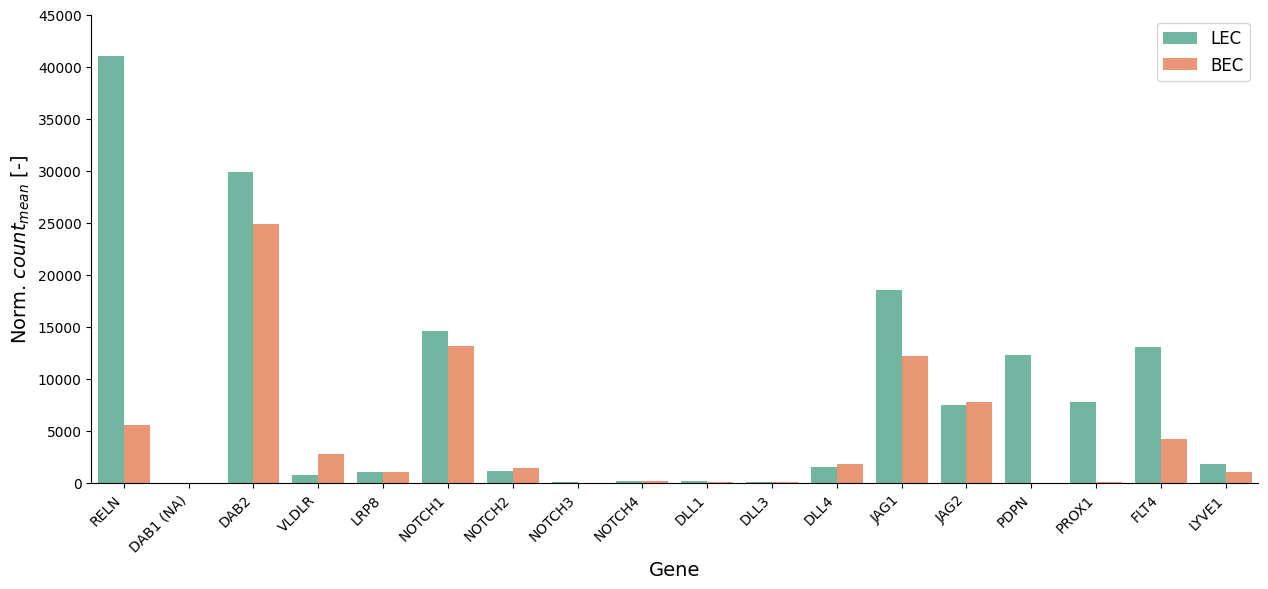

In [20]:
few_gene_nodes = ["RELN", "DAB1 (NA)", "DAB2", "VLDLR", "LRP8", 
                  "NOTCH1", "NOTCH2", "NOTCH3", "NOTCH4", 
                  "DLL1", "DLL3", "DLL4", "JAG1", "JAG2", 
                  "PDPN", "PROX1", "FLT4", "LYVE1"]

plt.figure(figsize=(16, 10))
g = sns.catplot(
    data=melted_norm, x="Gene", y="Mean_Count", hue="Condition", kind="bar",
    height=6, aspect=2, palette="Set2", order=few_gene_nodes
)
g.set_xticklabels(rotation=45, ha='right', fontsize=10)
g.set_yticklabels(fontsize=10)
g.set_axis_labels("Gene", r"Norm. $count_{mean}$ [-]", fontsize=14)
g._legend.remove()
plt.tight_layout()
plt.legend(fontsize=12, loc='best')
plt.savefig(r'.\GSE74322_outputs\GSE74322_DESeq2_norm_mean_counts_few_genes.png', dpi=600)
plt.show()

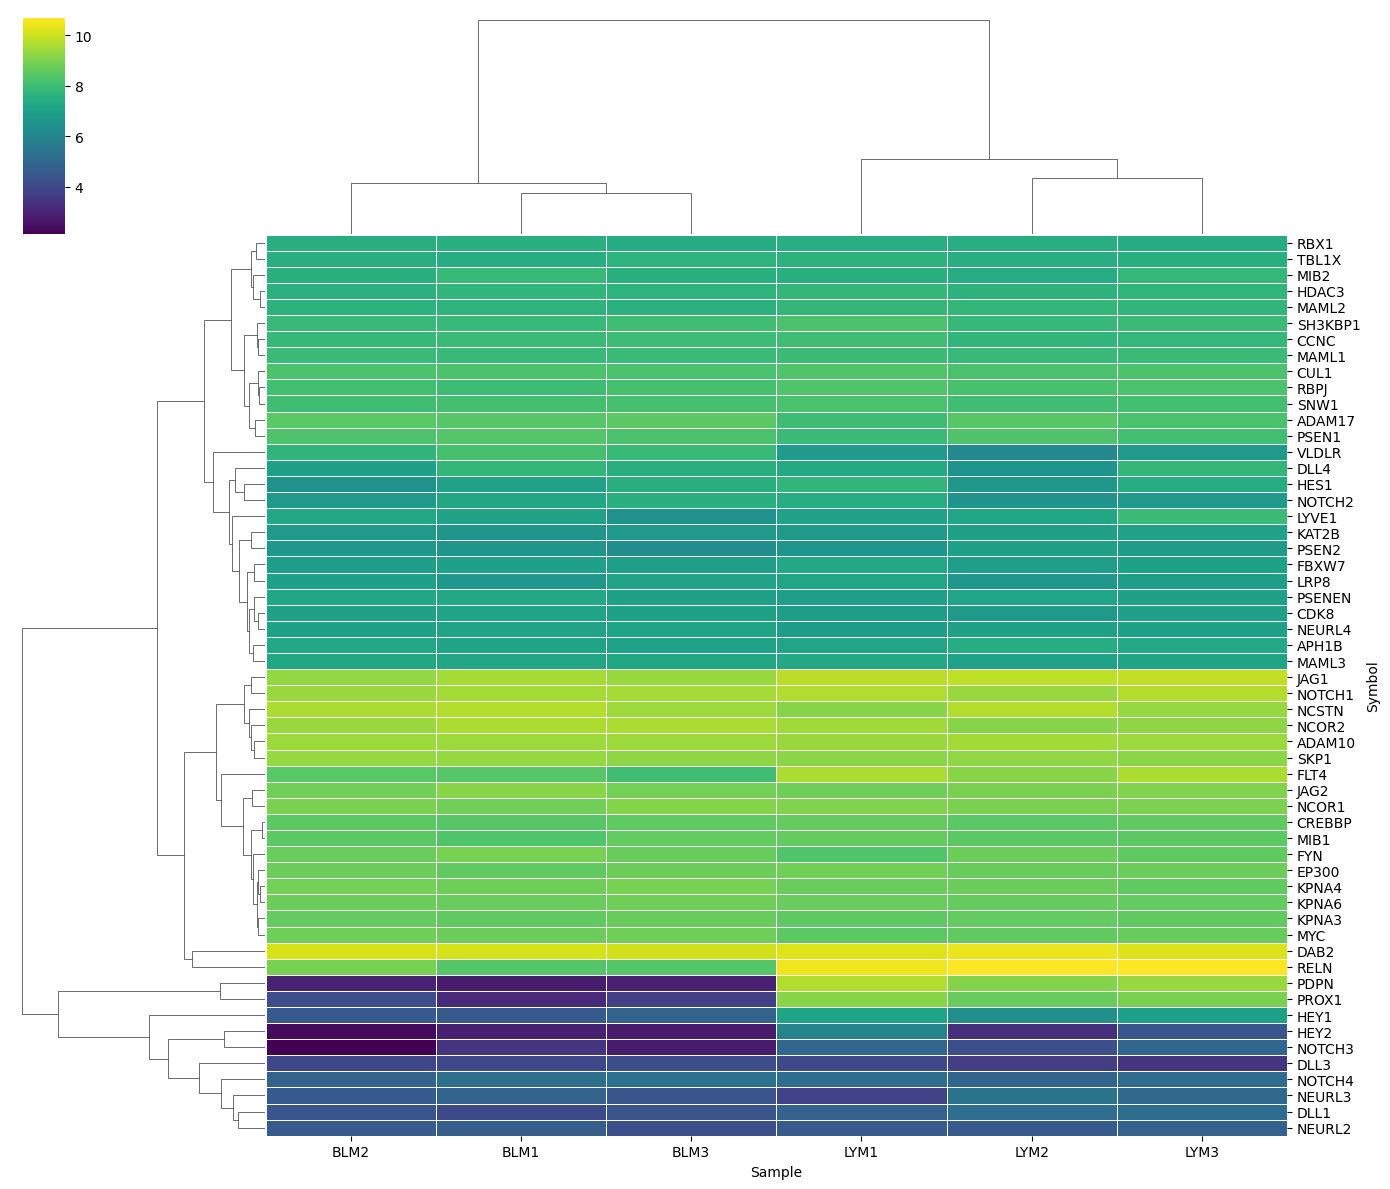

In [21]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

dds_signs = dds[:, dds.var_names.isin(gene_nodes)]
grapher = pd.DataFrame(dds_signs.layers['log1p'].T, index=dds_signs.var_names, columns=dds_signs.obs_names)

g = sns.clustermap(grapher, cmap='viridis', figsize=(14, 12), 
                   cbar_pos=(0.02, 0.8, 0.03, 0.18),
                   linewidths=0.5, col_cluster=True, row_cluster=True,
                   yticklabels=True, xticklabels=True)
g.fig.savefig(r'.\GSE74322_outputs\GSE74322_DESEq2_log1p.png', dpi=600)


In [22]:
log2_normed_counts = np.log2(dds.layers['normed_counts'] + 1)

log2_normed_counts_df = pd.DataFrame(
    log2_normed_counts.T,
    index=dds.var_names,
    columns=dds.obs_names
)

log2_normed_counts_df = log2_normed_counts_df.loc[log2_normed_counts_df.index.intersection(gene_nodes)]
log2_normed_counts_df.to_csv(r'.\GSE74322_outputs\GSE74322_DESeq2_log2_norm.csv', sep=',')

log2_normed_counts_df

Sample,BLM1,BLM2,BLM3,LYM1,LYM2,LYM3
Symbol,,,,,,
ADAM10,13.600164,13.549421,13.615920,13.504876,13.688669,13.537151
ADAM17,12.142078,12.250736,12.285232,11.575024,12.174393,11.884972
APH1B,10.280955,10.485723,10.161014,10.311768,10.710499,10.506407
CCNC,11.442099,11.323837,11.549793,11.638941,11.146298,11.293712
CDK8,10.290050,10.094389,10.151160,9.880053,9.743743,10.016708
CREBBP,12.181303,12.281603,12.377572,12.479631,12.262609,12.375357
CUL1,11.896249,11.864192,11.889434,11.994682,11.849727,11.932330
DAB2,14.601172,14.678906,14.520586,14.797908,15.036432,14.742762
DLL1,5.809328,6.317905,6.270579,6.867843,7.494119,7.444712


In [23]:
dds.varm['LFC']

,Intercept,Condition[T.LYM]
Symbol,,
61E3.4,6.632898,-0.210175
A1BG-AS1,4.852920,-0.061901
A2M,8.161832,0.567896
A2M-AS1,3.521207,0.427002
A4GALT,8.060364,-0.371690
...,...,...
hsa-mir-146a,5.540544,-0.365190
hsa-mir-3654,8.311726,0.067690
hsa-mir-6080,5.584673,-0.276565


In [24]:
log2fc = dds.varm['LFC']['Condition[T.LYM]']

results_df = pd.DataFrame({
    'log2FoldChange': log2fc
}, index=dds.var_names)

filtered_df = results_df[np.abs(results_df['log2FoldChange']) > 1]
filtered_df = filtered_df.loc[filtered_df.index.intersection(gene_nodes)] # Shows the log2 FC of genes of interest

filtered_df


,log2FoldChange
Symbol,
FLT4,-1.139352
HEY1,-2.261758
HEY2,-2.491049
NOTCH3,-1.881243
PDPN,-6.597382
PROX1,-5.208258
RELN,-2.002170
VLDLR,1.336922
